In [1]:
import ee
import numpy as np
import geemap.foliumap as geemap
import pprint
import pandas as pd
import altair as alt
import folium
import plotnine
from scipy import stats
# Set up a 'pretty printer' to print 'nicely' within Python
pp = pprint.PrettyPrinter(depth=3)

In [2]:
# Authenticate and initialize this instance of GEE in Google Colab
## Follow the prompts and fill in authentication code
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AZEOvhU4jzrrR2JFVbgmnx_7nLjA9RWerIR593KiAVrP8jhDQQHXAT-pk8w

Successfully saved authorization token.


In [44]:
# Start with an image collection for 2019 (Baseline)
# This code will grab an image collection from the TROPOMI data catalogue
# ... based on our parameters for band and date filter
Baseline2019 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2')\
        .select('tropospheric_NO2_column_number_density')\
        .filterDate('2019-03-23', '2019-06-23')\

# Note that slashes \ are used in the code above to allow another line of code for 
# formatting appearance (the code could all be on one long line, if you wanted).
# In some cases, code automatically continues to the next line, e.g. when there are commas,
# but sometimes we need to tell the code that we are continuing on the next line with a \.

# Get the median pixel value for 2019's study period by observation
# This is a temporal reducer
Baseline2019Median = Baseline2019.median()

# For Tropospheric concentrations, this is considered a 'reasonable range' to visualize at.
# Feel free to change it to analyze different ranges of particulate density.
# You can also try some other colour palettes linked below
vis_params= {
  'min': 0,
  'max': 0.0002,
  'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
};

# This set of code will use the geemap package to display the map within your Colab
# environment, of the rates of atmospheric NO2 in 2019
Map = geemap.Map()
Map.addLayer(Baseline2019Median,visParams,'2019 "Baseline" NO2 Levels')
Map.addLayerControl()
# This is Arkhangelsk
Map.setCenter(40.5,64.5)
Map

In [48]:
# We will now get an image collection for 2020
Baseline2020 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2')\
        .select('tropospheric_NO2_column_number_density')\
        .filterDate('2020-01-23', '2020-11-23')\

# Note that slashes \ are used in the code above to allow another line of code for 
# formatting appearance (the code could all be on one long line, if you wanted).
# In some cases, code automatically continues to the next line, e.g. when there are commas,
# but sometimes we need to tell the code that we are continuing on the next line with a \.

# Get the median pixel value for 2020's study period
# This is a temporal reducer
Baseline2020Mean = Baseline2020.mean()

vis_params= {
  'min': 0,
  'max': 0.00008,
  'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
};

Map = geemap.Map()
Map.addLayer(Baseline2020Median,visParams,'2020 "Pandemic" NO2 Levels')
Map.addLayerControl()
Map.setCenter(40.5,64.5)
Map

In [7]:
# Define a function (and embedded function) for reducing a region for charting
# See the function descriptions defined in red within the functions

def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.median(),
                                  scale=1113.2,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):
  """Creates a region reduction function.

  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.

  """

  def reduce_region_function(img):
    """
      Function returns
      An ee.Feature that contains properties representing the image region
      reduction results per band and the image timestamp formatted as
      milliseconds from Unix epoch (included to enable time series plotting).
    """

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function


In [39]:
# Let's gather some TROPOMI NO2 data as we did above, for a 2019 baseline
NO2Baseline = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2')\
        .select('tropospheric_NO2_column_number_density')\
        .filterDate('2019-03-23', '2019-06-23');

# Define an area of interest (aoi)
# We will look at the GTA (broad definition)
aoi = ee.Geometry.Polygon([[40.69265, 65.0689],
                           [41.782,65.0689],
                           [40.782,66.472],
                           [41.6965,66.472],
                           ])

In [40]:
# Let's gather some TROPOMI NO2 data as we did above, for our 2020 lockdown study period
NO2Lockdown = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2')\
        .select('tropospheric_NO2_column_number_density')\
        .filterDate('2020-03-23', '2020-06-23');


In [42]:
# Check out the AOI if you want to visualize it (can also be used to create your own AOI)
# If you've seen enough of the GTA, you can skip this step (you'll have to scroll to the GTA to find the study area, potentially)
Map = geemap.Map()
Map.addLayer(aoi,{},'AOI')
Map.setCenter(40, 65, 8)
Map

In [11]:
# Use the above defined function to create a reducing function specific to our data
## We are going to leave most of the arguments as their defaults (see the above code)
## except geometry which we set to our aoi, the reducer which we will set as the median
reduce_NO2 = create_reduce_region_function(
    geometry=aoi, reducer=ee.Reducer.median())

# Convert the image collection to a feature collection with the reducer function
## this step just applies the function we created above (reduce_sst), with its defined inputs to our
## image collection for 2019
NO2_stat_fc = ee.FeatureCollection(NO2Baseline.map(reduce_NO2))
# Filter out null values based on bandnames of the first image in the feature collection
NO2_stat_fc = NO2_stat_fc.filter(ee.Filter.notNull(NO2Baseline.first().bandNames()))

In [12]:
# Use the above defined function to create a reducing function specific to our data
## We are going to leave most of the arguments as their defaults (see the above code)
## except geometry which we set to our aoi, the reducer which we will set as the median
reduce_NO2 = create_reduce_region_function(
    geometry=aoi, reducer=ee.Reducer.median())
# Convert the image collection to a feature collection with the reducer function
## this step just applies the function we created above (reduce_sst), with its defined inputs to our
## image collection for 2020
NO2_stat_fc_2020 = ee.FeatureCollection(NO2Lockdown.map(reduce_NO2))
# Filter out null values based on bandnames of the first image in the feature collection
NO2_stat_fc_2020 = NO2_stat_fc_2020.filter(ee.Filter.notNull(NO2Lockdown.first().bandNames()))

In [13]:
# Define a function to transfer feature properties to a dictionary.
# We use this to convert our earth engine object (reduced image collection) to a 
# collection of properties and their values 

def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

In [14]:
# Convert feature collection to dictionary and use .getInfo() to transfer to our own computers
NO2Baseline_dict = fc_to_dict(NO2_stat_fc).getInfo()

In [15]:
# Convert feature collection to dictionary and use .getInfo() to transfer to our own computers
NO2COVID_dict = fc_to_dict(NO2_stat_fc_2020).getInfo()

In [16]:
# Conversion of dictionary to dataframe for pandas usage for both years
NO2COVID_df = pd.DataFrame(NO2COVID_dict)
NO2Baseline_df = pd.DataFrame(NO2Baseline_dict)

In [18]:
# Function to add date variables to DataFrame.
# This function just uses pandas functions on the millis column within our dataset to create date time columns

def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
  df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
  return df


In [19]:
# apply the date info function to the dataframe
NO2Baseline_df = add_date_info(NO2Baseline_df)
NO2COVID_df = add_date_info(NO2COVID_df)
# Rename the sst column SST and remove the unnecessary millis and system:index columns, also renaming our columns to make them easier to read
NO2COVID_df = NO2COVID_df.rename(columns={
    'tropospheric_NO2_column_number_density': 'Median NO2 Concentration (mol/m2)'
}).drop(columns=['millis', 'system:index'])
NO2Baseline_df = NO2Baseline_df.rename(columns={
    'tropospheric_NO2_column_number_density': 'Median NO2 Concentration (mol/m2)'
}).drop(columns=['millis', 'system:index'])

In [21]:
NO2Baseline_df

,Median NO2 Concentration (mol/m2),Timestamp,Year,Month,Day,DOY
0,0.000021,2019-03-23 17:00:31,2019,3,23,82
1,0.000023,2019-03-23 18:42:01,2019,3,23,82
2,0.000043,2019-03-24 16:41:36,2019,3,24,83
3,0.000034,2019-03-24 18:23:06,2019,3,24,83
4,0.000016,2019-03-25 16:22:40,2019,3,25,84
...,...,...,...,...,...,...
85,0.000043,2019-06-19 17:57:08,2019,6,19,170
86,0.000063,2019-06-20 17:38:06,2019,6,20,171
87,0.000020,2019-06-21 17:19:03,2019,6,21,172
88,0.000022,2019-06-22 17:00:00,2019,6,22,173


In [31]:
bigDataset

,Median NO2 Concentration (mol/m2),Timestamp,Year,Month,Day,DOY
0,0.000021,2019-03-23 17:00:31,2019,3,23,82
1,0.000023,2019-03-23 18:42:01,2019,3,23,82
2,0.000043,2019-03-24 16:41:36,2019,3,24,83
3,0.000034,2019-03-24 18:23:06,2019,3,24,83
4,0.000016,2019-03-25 16:22:40,2019,3,25,84
...,...,...,...,...,...,...
103,0.000032,2020-06-19 18:35:30,2020,6,19,171
104,0.000033,2020-06-20 16:34:58,2020,6,20,172
105,0.000030,2020-06-20 18:16:27,2020,6,20,172
106,0.000027,2020-06-21 17:57:25,2020,6,21,173


/home/kglin/anaconda3/lib/python3.7/site-packages/plotnine/stats/smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


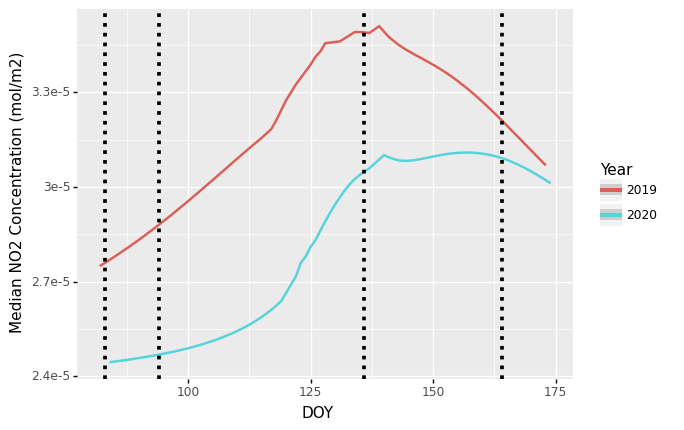

<ggplot: (8737272126429)>

In [38]:
from plotnine import ggplot, aes, geom_line,geom_smooth,geom_vline
# Let's combine both datasets so we can plot them both on the same line graph.
bigDataset = NO2Baseline_df.append(NO2COVID_df)
# Change the 'Year' variable to a string for this purpose, as it makes the year more 'categorical' on the map.
bigDataset.Year = bigDataset.Year.astype(str)
(
    ggplot(data = bigDataset, mapping = aes(x = 'DOY', y = 'Median NO2 Concentration (mol/m2)', color = 'Year'))
    # Smoothed line instead of straight (confidence interrvals not implemented in this package)
    + geom_smooth() + geom_vline(xintercept= [83, 94, 136, 164], linetype = 'dotted', size = 1.5)
)


In [34]:
import plotnine